# Reinforcement learning

In [1]:
import numpy as np
import keras_tuner
import keras
import pandas as pd
import tensorflow as tf
from dataclasses import dataclass

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

pd.options.display.max_columns = 200
keras.utils.set_random_seed(42)

Using TensorFlow backend


In [2]:
@dataclass
class ProcessedData:
  def __init__(self, X, y):
    self.X = X.copy()
    self.y = y.copy(deep=True)

  def copy(self):
    return ProcessedData(self.X.copy(), self.y.copy())

In [3]:
#X = pd.read_csv("./data/4/X.csv", header=None)
y = pd.read_csv("./data/14/y.csv", header=None)
X = pd.read_csv("./data/14/diff.csv", header=None)
print(y.shape)
#print(X.shape)
print(X.shape)

(3575, 1)
(3575, 2040)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
smoteenn = RandomUnderSampler(random_state=42)
X_train, y_train = smoteenn.fit_resample(X_train, y_train)

In [6]:
X_train = X_train.to_numpy().reshape(-1, 40, 51, 1)
X_test = X_test.to_numpy().reshape(-1, 40, 51, 1)

In [7]:
X_train.shape

(570, 40, 51, 1)

In [8]:
#diff_images = []

#for i in range(1, X_res_2D.shape[0]):
#    diff = X_res_2D[i] - X_res_2D[i-1]
#    diff_images.append(diff)

#diff_images_array = np.array(diff_images)
#y_res_2 = y_res.drop(index=y.index[0], axis=0)

In [9]:
#y_res_2.shape

In [10]:
#diff_images_array.shape

In [11]:
y_train.groupby(0)[0].count()

0
0    190
1    190
2    190
Name: 0, dtype: int64

# The dataset is not balanced

In [12]:
sklearn_class_weights = compute_class_weight(class_weight="balanced", classes=y[0].unique(), y=y[0])
class_weight = {}
for i, weight in enumerate(sklearn_class_weights):
    class_weight[i] = weight
    #if i != 0:
    #    class_weight[i] *= 2
    
print(class_weight)

{0: 0.403954802259887, 1: 4.673202614379085, 2: 3.220720720720721}


In [13]:
#X_train, X_test, y_train, y_test = train_test_split(X_res_2D, y_res)

In [14]:
train = ProcessedData(X_train, y_train)
test = ProcessedData(X_test, y_test)

In [15]:
# Extension de la classe BayesianOptimization pour permettre l'accès aux historiques des modèles entrainés.
class BayesianOptimization(keras_tuner.BayesianOptimization):
    histories = {}

    # À la fin de chaque époque, on ajoute les métriques à l'historique de l'essai en cours
    def on_epoch_end(self, trial, model, epoch, logs=None):
        trial_id = trial.trial_id
        trial_history = self.histories.setdefault(trial_id, {})
        for metric, value in logs.items():
            trial_history.setdefault(metric, []).append(value)

In [16]:
def build_model(hp):
    
    input = Input(shape=(40, 51, 1))
    # Optimisation du réseau de neurone

    #if hp.Boolean("Dense", default=False):
    #    x = Flatten()(input)
    #    x = Dense(hp.Int(f'units_0', 8, 64, step=16), activation='relu')(x)
    #    for i in range(hp.Int('layers', 0, 4)):
    #        x = Dense(hp.Int(f'units_{str(i+1)}', 8, 64, step=16), activation='relu')(x)
    #else:abs
    x = Conv2D(hp.Int(f'filter_0', 3, 9, step=3), hp.Int(f'kernel_size_0', 3, 5, step=2), activation='relu')(input)
    for i in range(hp.Int('layers', 0, 4)):
        x = Conv2D(hp.Int(f'filter_{str(i+1)}', 3, 9, step=3), hp.Int(f'kernel_size_{str(i+1)}', 3, 9, step=2), activation='relu')(x)
        if hp.Boolean("WithMaxPool", default=False):
            x = MaxPooling2D(hp.Int(f'max_pool_size_{str(i+1)}', 2, 6, step=2), strides=hp.Int(f'max_pool_strides_{str(i+1)}', 1, 4, step=10), padding='same')(x)
    x = Flatten()(x)

    output = Dense(3, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=10)

early_stopping_cb = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=1, mode='max', baseline=None, restore_best_weights=True)
tuner.search(train.X, train.y, validation_split=0.2, epochs=1000, callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 08s]
val_accuracy: 0.22807016968727112

Best val_accuracy So Far: 0.5701754689216614
Total elapsed time: 00h 01m 05s


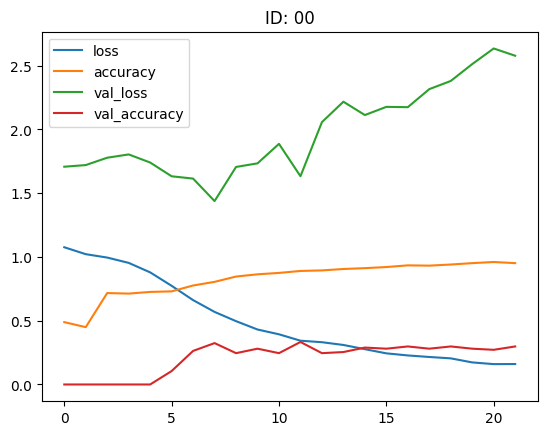

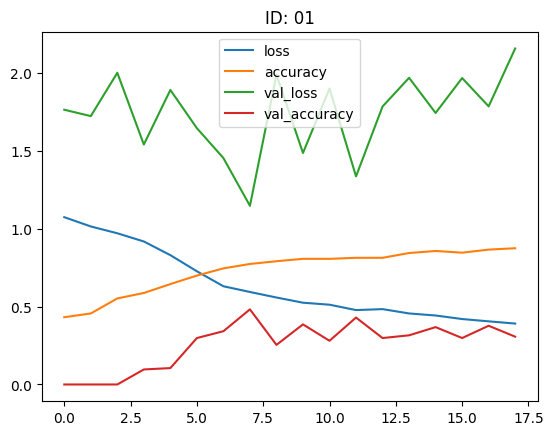

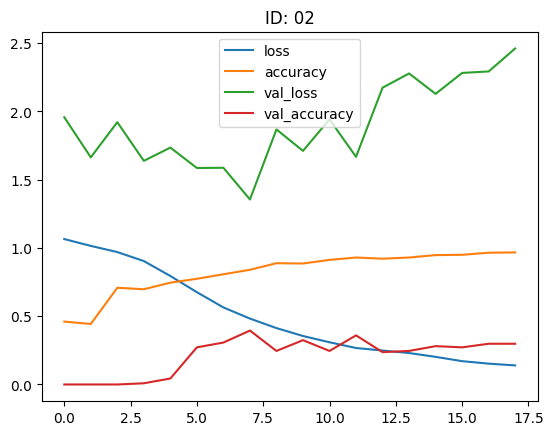

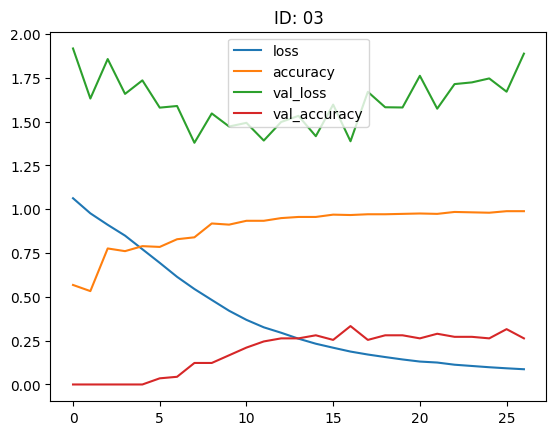

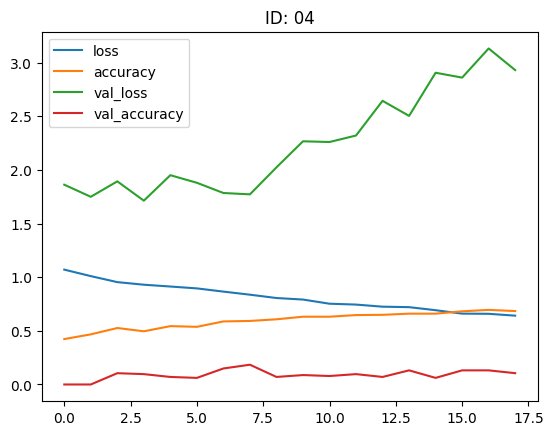

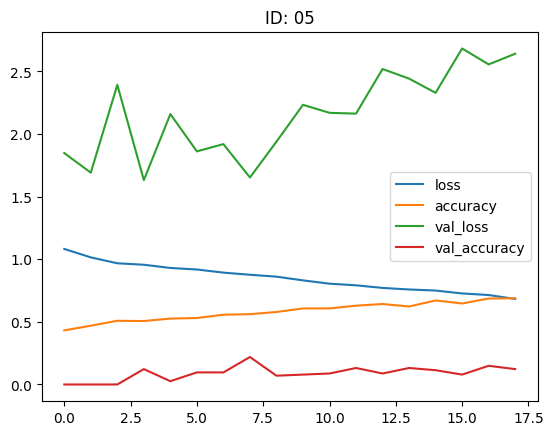

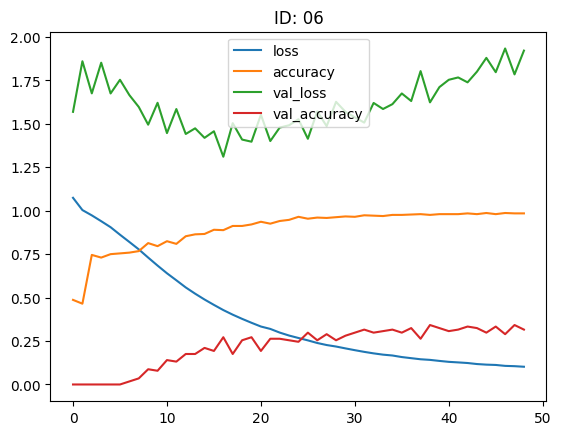

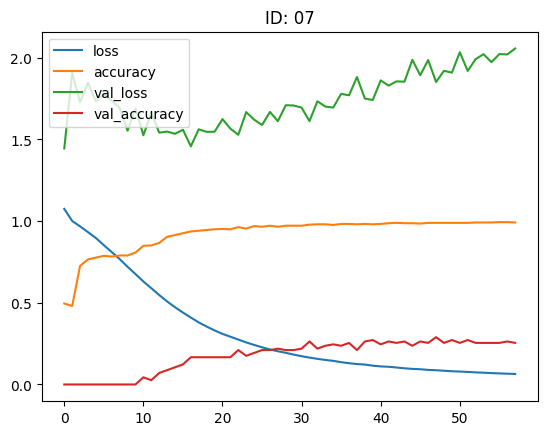

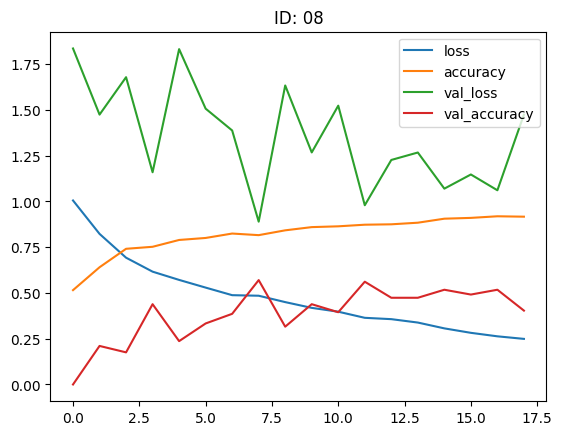

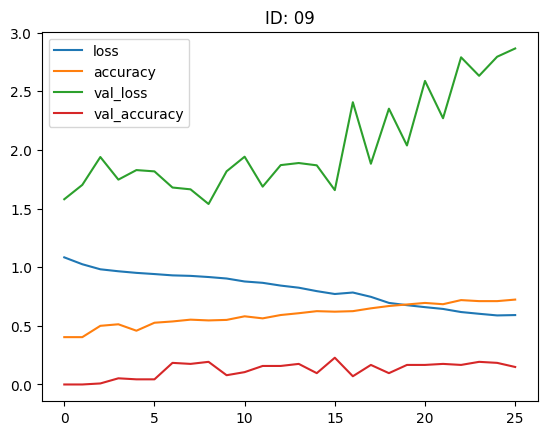

In [17]:
for id, history in tuner.histories.items():
    pd.DataFrame(history).plot(title=f"ID: {id}")

In [18]:
best_model = tuner.get_best_models()[0]

In [19]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 51, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 38, 49, 3)         30        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 43, 6)         888       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 43, 6)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8256)              0         
                                                                 
 dense (Dense)               (None, 3)                 24771     
                                                             

28/28 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       741
           1       0.29      0.66      0.41        65
           2       0.40      0.58      0.48        88

    accuracy                           0.78       894
   macro avg       0.55      0.68      0.59       894
weighted avg       0.86      0.78      0.81       894



2023-10-04 00:52:41.412112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


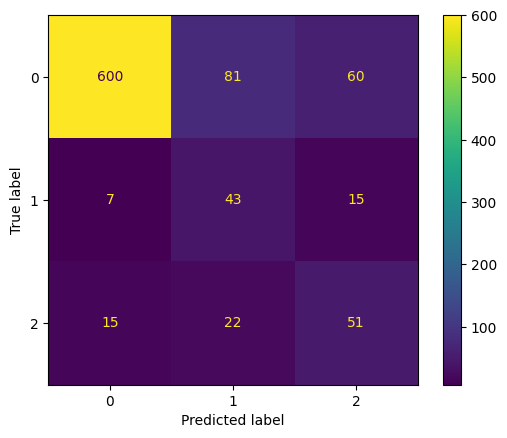

In [20]:
y_pred = best_model.predict(test.X)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(test.y, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test.y, y_pred)).plot()

In [21]:
best_model.save(f"./models/pong-13.h5")

/Users/Sami/polytech/jupyter-env/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
